We will model the dynamics of the car as with a simple nonlinear bicycle model, with the following state and control:

$$\begin{align} x = \begin{bmatrix} p_x \\ p_y \\ \theta \\ \delta \\ v \\ \omega \end{bmatrix}, &\quad \quad u = \begin{bmatrix} a \\ \dot{\delta} \end{bmatrix}  \end{align} $$ 

where $p_x$ and $p_y$ describe the 2d position of the bike, $\theta$ is the orientation, $\delta$ is the steering angle, and $v$ is the velocity. The controls for the bike are acceleration $a$, and steering angle rate $\dot{\delta}$.  

In [32]:

import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 

  Activating environment at `~/Desktop/courses/ocrl/OptimizationProj/Project.toml`


In [33]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","ilc_visualizer.jl"))

vis_traj! (generic function with 1 method)

In [34]:
function estimated_car_dynamics(model::NamedTuple, x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    
    β = atan(model.lr * δ, model.L)
    s,c = sincos(θ + β)
    ω = v*cos(β)*tan(δ) / model.L
    
    vx = v*c 
    vy = v*s 
    
    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
    
    return xdot 
end
function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u)
    k2 = dt * ode(model, x + k1/2, u)
    k3 = dt * ode(model, x + k2/2, u)
    k4 = dt * ode(model, x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   

rk4 (generic function with 1 method)

In [35]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    xmid = 0.5 * (x1 + x2) + (dt/8) * (estimated_car_dynamics(params,x1, u) - estimated_car_dynamics(params,x2, u))
    return x1 + ((dt/6) * (estimated_car_dynamics(params,x1, u) + 4*estimated_car_dynamics(params,xmid, u) + estimated_car_dynamics(params,x2, u))) - x2
end

hermite_simpson (generic function with 1 method)

In [37]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function fig8_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    XRef = params.XRef
    
    
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        xi1 = Z[idx.x[i+1]]
        # xref_i = XRef[i,:]
        xref_i = XRef[:,i]

        # println(size(XRef))
        # println(xref_i)
        # println(xi)

        # x_dist = xi - xg
        x_dist = xi - xref_i
        x_dist[3] = 0
        x_dist[4] = 0
        x_dist[5] = 0

        x_cost = 0.5 * x_dist' * Q * x_dist
        u_cost = 0.5 * ui' * R * ui
       
        J += x_cost + u_cost

    end
    
    # dont forget terminal cost 
    xn = Z[idx.x[N]]

    x_dist = xn - xg
    J += 0.5 * x_dist' * Qf * x_dist
    
    return J 
end

function fig8_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 
    
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function fig8_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    # TODO: return all of the equality constraints 
    
    # get x0 and xN
    x0 = Z[idx.x[1]]
    xN = Z[idx.x[N]]

    constraint1 = x0 - xic
    constraint2 = xN - xg
    dyn = fig8_dynamics_constraints(params, Z)

    c = [constraint1; constraint2; dyn]

    return c
    # return zeros(10) # 10 is an arbitrary number 
end

function solve_fig8()
    
    # problem size 
    nx = 5 
    nu = 2 
    # dt = 0.05
    dt = 0.2
    tf = 20.0 
    # tf = 10.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = diagm(ones(nx)) * 10
    R = 1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
 
    y = range(0, stop=4, length=100)
    x = 0.5 * (y.^2)
    XRef = zeros(5, 100)

    for i in 1:100
        XRef[1, i] = x[i]
        XRef[2, i] = y[i]
        XRef[3, i] = 0
        XRef[4, i] = 0
        XRef[5, i] = 1
    end

    xic = [0, 0, 1, 0, 0]
    xg = [8, 4, 0, 0, 0]

    x = range(0, stop=10, length=100)
    y = 0 * x

    # XRef = zeros(5, 100)
    # for i in 1:100
    #     XRef[1, i] = x[i]
    #     XRef[2, i] = y[i]
    #     XRef[3, i] = 0
    #     XRef[4, i] = 0
    #     XRef[5, i] = 1
    # end

    # xic = [0, 0, 0, 0, 0]
    # xg = [10, 0, 3.14, 0, 0]


    model = (L=2.8, lr=1.6)

    params = (XRef = XRef, Q=Q, R=R, Qf=Qf, xic=xic, xg=xg, dt = dt, N = N, idx = idx, L=2.8, lr=1.6, model=model) 
    
    # TODO: primal bounds 
    println("N :", N)
    x_l = -Inf * ones(idx.nz)
    x_u = Inf * ones(idx.nz)
    for i = 1:(N-1)
        x_l[idx.u[i][1]] = -0.5
        x_u[idx.u[i][1]] = 0.5

        x_l[idx.x[i][4]] = -1
        x_u[idx.x[i][4]] = 1

        # x_l[idx.x[i][5]] = 0
        # x_u[idx.x[i][5]] = 10
    end

    # print(x_l)

    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    z0 = 0.001*randn(idx.nz)
    println("idx: ", idx)
    println("N: ", N)
    
    # choose diff type (try :auto, then use :finite if :auto doesn't work)
    diff_type = :auto 
#     diff_type = :finite
    
    
    Z = fmincon(fig8_cost,fig8_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = true)
    
    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, t_vec, params 
end



solve_fig8 (generic function with 1 method)

In [38]:
X, U, t_vec = solve_fig8()    

N :101
idx: (nx = 5, nu = 2, N = 101, nz = 705, nc = 500, x = UnitRange{Int64}[1:5, 8:12, 15:19, 22:26, 29:33, 36:40, 43:47, 50:54, 57:61, 64:68, 71:75, 78:82, 85:89, 92:96, 99:103, 106:110, 113:117, 120:124, 127:131, 134:138, 141:145, 148:152, 155:159, 162:166, 169:173, 176:180, 183:187, 190:194, 197:201, 204:208, 211:215, 218:222, 225:229, 232:236, 239:243, 246:250, 253:257, 260:264, 267:271, 274:278, 281:285, 288:292, 295:299, 302:306, 309:313, 316:320, 323:327, 330:334, 337:341, 344:348, 351:355, 358:362, 365:369, 372:376, 379:383, 386:390, 393:397, 400:404, 407:411, 414:418, 421:425, 428:432, 435:439, 442:446, 449:453, 456:460, 463:467, 470:474, 477:481, 484:488, 491:495, 498:502, 505:509, 512:516, 519:523, 526:530, 533:537, 540:544, 547:551, 554:558, 561:565, 568:572, 575:579, 582:586, 589:593, 596:600, 603:607, 610:614, 617:621, 624:628, 631:635, 638:642, 645:649, 652:656, 659:663, 666:670, 673:677, 680:684, 687:691, 694:698, 701:705], u = UnitRange{Int64}[6:7, 13:14, 20:21, 27:

---------testing constraint Jacobian----------------


---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:   359550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      705
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:      510
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

([[0.0, 0.0, 1.0, 0.0, 0.0], [0.0038091736780534887, 0.00631589407030167, 1.0001293873050947, 0.07363218127725432, 0.0737602328044906], [0.013972543085256002, 0.024626019403357853, 1.0009645858376925, 0.1423978224571102, 0.13567032616252228], [0.028447441029811896, 0.05313344304764774, 1.002961507244581, 0.20243895856496477, 0.1840647890606176], [0.045503178183830865, 0.08965020095959166, 1.006267080804365, 0.25122370416570716, 0.2189859956794916], [0.06384216908614092, 0.13190778862508754, 1.010761540013696, 0.2874901980592886, 0.241679881999483], [0.08259829929313778, 0.17780315237352476, 1.0161484951560944, 0.3110249474936092, 0.2541271973000175], [0.10126824830676509, 0.22555993876747563, 1.022054731415644, 0.3223772002400286, 0.2586407999981919], [0.11962049745782066, 0.27380640698744857, 1.0281127866546804, 0.32258018603435085, 0.2575505596977697], [0.13760986476793316, 0.32158537642481344, 1.0340134511300754, 0.31291869492178964, 0.2529832124271406]  …  [7.234358249320538, 4.252

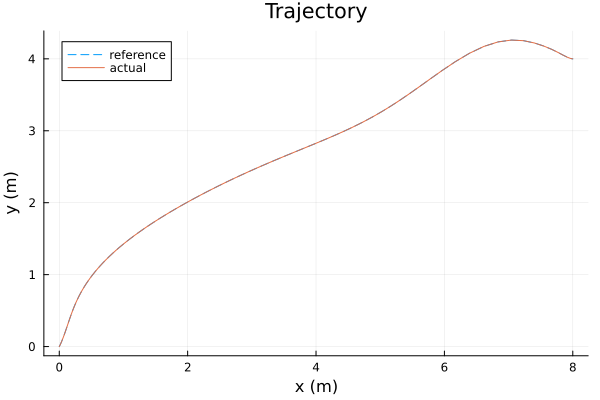

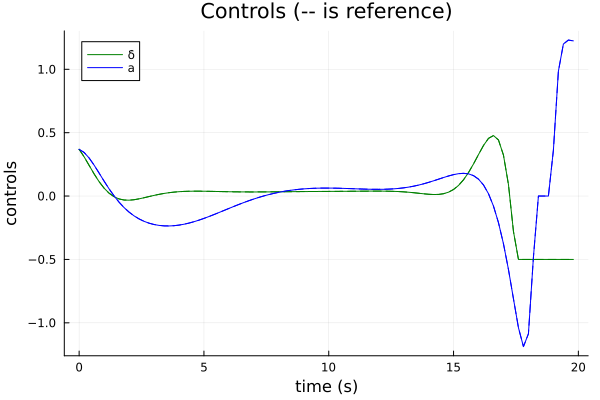

UndefVarError: UndefVarError: Visualizer not defined

In [39]:
tf = 20

Xm = hcat(X...)
Um = hcat(U...)
Xrefm = hcat(X...)
Urefm = hcat(U...)
plot(Xrefm[1, :], Xrefm[2, :], ls=:dash, label="reference",
    xlabel="x (m)", ylabel="y (m)", title="Trajectory")
display(plot!(Xm[1, :], Xm[2, :], label="actual"))

plot(t_vec[1:end-1], Urefm', ls=:dash, lc=[:green :blue], label="",
    xlabel="time (s)", ylabel="controls", title="Controls (-- is reference)")
display(plot!(t_vec[1:end-1], Um', label=["δ̇" "a"], lc=[:green :blue]))


# Animation
vis = Visualizer()
X_vis = [[x[1], x[2], 0.1] for x in X]
vis_traj!(vis, :traj, X_vis; R=0.02)
vis_model = TrajOptPlots.RobotZoo.BicycleModel()
TrajOptPlots.set_mesh!(vis, vis_model)
X_o = [x[SA[1, 2, 3, 4]] for x in X]
visualize!(vis, vis_model, tf, X_o)
display(render(vis))
    

In [31]:
jldsave("utils/threePoint.jld2"; X,U)

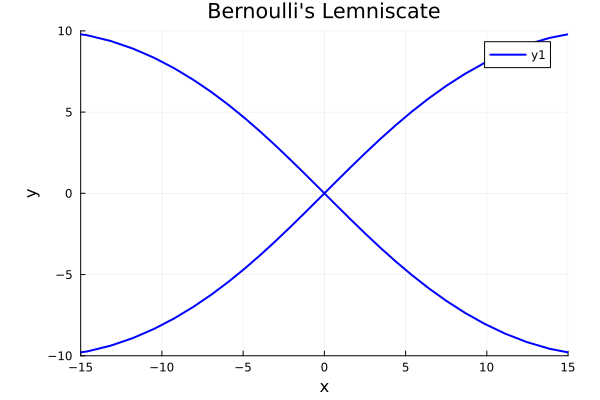

In [8]:
using Plots

# Create the t array
t = range(0, 2π, length=100)

# Define the a parameter
a = 5

# Define the x and y coordinates of the lemniscate
x = a * sqrt(2) * cos.(t) ./ (sin.(t).^2 .+ 1)
y = a * sqrt(2) * cos.(t) .* sin.(t) ./ (sin.(t).^2 .+ 1)

x *= 4
y *= 4


# Plot the lemniscate
plot(x, y, color=:blue, linewidth=2, aspect_ratio=:equal, xlims=(-15, 15), ylims=(-10, 10), xlabel="x", ylabel="y", title="Bernoulli's Lemniscate")


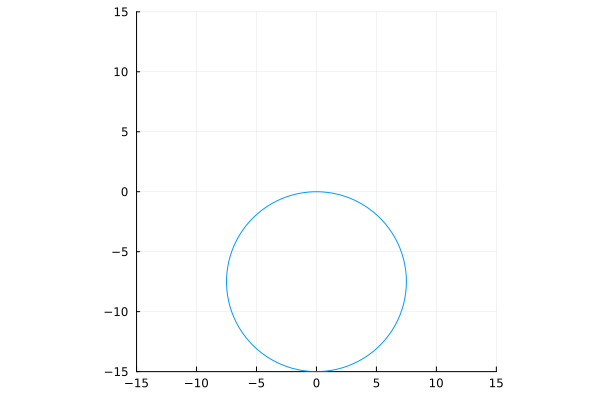

In [9]:
using Plots

# Define center and radius of circle
center = (0, -7.5)
radius = 7.5

# Create a range of values for the angle theta
theta_range = range(0, stop=2π, length=100)

# Compute the x and y coordinates of the circle
x = center[1] .+ radius .* cos.(theta_range)
y = center[2] .+ radius .* sin.(theta_range)

# Create a plot of the circle
plot(x, y, aspect_ratio=1, xlims=(-15, 15), ylims=(-15, 15), legend=false)